In [6]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 20000   # encok kullanılan n kelmeyi kullan
maxlen = 100 # her yorumun uzunlugu

(x_train, y_train), (x_test,y_test) = imdb.load_data(num_words = max_features)

# yorumların uzunlaklarını 100 olacak sekilde ayarla
x_train = pad_sequences (x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

word_index = imdb.get_word_index() 

# kelime dizinin geri dondurmk için ters cevirelim 
reverse_word_index = {index+3: word for word, index in word_index.items() } # ters dizini
reverse_word_index[0] = "<PAD>" # PAD ile eslestir
reverse_word_index[1] = "<START>" 
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

# ornek metinleri yazdırma
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(word, "?") for word in encoded_review]) # her sayiyi kelimeyi cevir

random_indices = np.random.choice(len(x_train), size=3, replace = False) # rastgele 3 yorum sec
for i in random_indices:
    print(f"Yorum : {decode_review(x_train[i])},'\n'")
    print(f"etiket : {y_train[i]}")
    print()



Yorum : think one of carlito's long time friends would make an appearance in the original carlito <UNK> out being released from jail after spending 5 years in jail that's only a few <UNK> between the end of the prequel and the start of the original semi spoiler we know from the beginning of the original carlito has spent 5 years in prison so when the prequel gives us this hollywood happy ending it's an insult to the intelligence of fans of the original what happen to gail it's the lack of continuity that made this film go direct to video release,'
'
etiket : 0

Yorum : how you can go from clockwork orange to this crap and be able to look yourself in the mirror each morning i could have done better special effects in my bathtub there's no continuity the editor must have been asleep or on drugs its so bad acting do they have to smoke to be bad the gun either shoots blue flames or bullets make up your mind the bad girl and the other girl in the movie look so much alike that it is confusin

In [16]:
# Transformers Blok

class TransformerBlock(layers.Layer):
    def __init__(self, embed_size, heads ,dropout_rate =0.3):
        super(TransformerBlock, self).__init__()

        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim = embed_size)
        self.norm1 = layers.LayerNormalization(epsilon = 1e-6) # 1. normalizasyon katmanımız.
        self.norm2 = layers.LayerNormalization(epsilon = 1e-6) # 2. normalizasyon katmanımız.
 
        self.feed_foward = models.Sequential([
            layers.Dense(embed_size*4, activation = "relu"),
            layers.Dense(embed_size)
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training):
        # dikkat (attention ) mekanizmasını uygulama
        attention = self.attention(x, x)
        x = self.norm1(x + self.dropout1(attention, training = training))
        feed_forward = self.feed_foward(x)
        return self.norm2(x + self.dropout2(feed_forward, training = training))
    
# Transformers Modeli

class TransformerModel(models.Model):
    def __init__(self, num_layers,embed_size, heads, input_dim, output_dim , dropout_rate = 0.3):
        super(TransformerModel, self).__init__()

        self.embedding = layers.Embedding(input_dim=input_dim, output_dim=embed_size)
        self.transformer_blocks = [TransformerBlock(embed_size, heads, dropout_rate) for _ in range(num_layers)]
        self.global_avg_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(output_dim, activation = "sigmoid")

    def call(self, x, training):
        x = self.embedding(x)
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
            x = self.global_avg_pool(x)
            x = self.dropout(x, training=training)
            return self.fc(x)
        
# Modeli olusturma

num_layers = 4 
embed_size = 64
num_heads = 4
input_dim = max_features
output_dim = 1 # ikli sınuflafırma 1-0
dropout_rate = 0.1

model = TransformerModel(num_layers, embed_size, num_heads, input_dim, output_dim, dropout_rate)

# Dummy input ile modeli çağırın
dummy_input = tf.random.uniform((1, maxlen), minval=0, maxval=input_dim, dtype=tf.int32)
_ = model(dummy_input, training=False)  # Modelin yapısını oluşturun

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()


c:\Users\mrtmm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:395: UserWarning: `build()` was called on layer 'transformer_model_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_model_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (1, 200, 64)           │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_52            │ ?                      │        99,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_53            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_54            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_55            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_13     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (1, 1)                 │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,777 (5.26 MB)

 Trainable params: 1,379,777 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# model egitimi 

history = model.fit(x_train, y_train, batch_size = 128, epochs = 4, validation_data = (x_test, y_test))

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 87s 393ms/step - accuracy: 0.7095 - loss: 0.5451 - val_accuracy: 0.8383 - val_loss: 0.3672
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 70s 359ms/step - accuracy: 0.9119 - loss: 0.2236 - val_accuracy: 0.8316 - val_loss: 0.3874
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.9404 - loss: 0.1568 - val_accuracy: 0.8364 - val_loss: 0.4402
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 345ms/step - accuracy: 0.9634 - loss: 0.1033 - val_accuracy: 0.8240 - val_loss: 0.5137


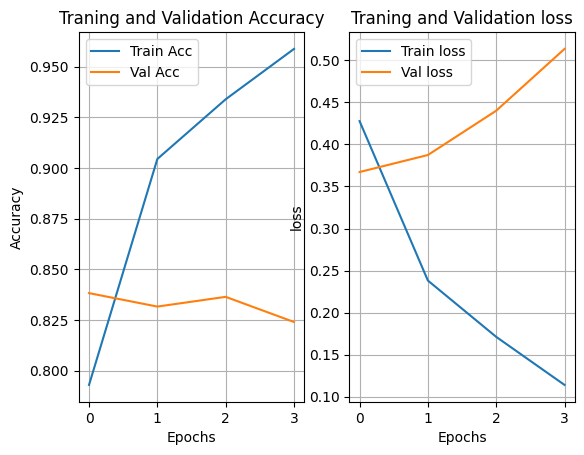

In [18]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Traning and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('True')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Traning and Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('True')

In [21]:
def predict_sentiment(model, text, word_index, maxlen):

    # metni imdb formatında sayıya çevir
    encoded_text = [word_index.get(word, 0) for word in text.lower().split()]
    padded_text = pad_sequences([encoded_text], maxlen=maxlen) # padding uygula
    prediction = model.predict(padded_text) # tahmin yap
    return prediction[0][0]

# kullanıcıdan yorum al
user_input = input("Yorum gir: ")
sentiment_score = predict_sentiment(model, user_input, word_index, maxlen)

if sentiment_score >= 0.5:
    print("olumsuz yorum")
else:
    print("olumlu yorum")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
olumlu yorum
